In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [58]:
## Read csv file
df = pd.read_csv('train_all_tasks.csv')

In [59]:
## Data pre-processing

In [60]:
# text and labels for task A
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df['text'], df['label_sexist'], test_size=0.3, random_state=0)
X_test_a, X_dev_a, y_test_a, y_dev_a = train_test_split(X_test_a, y_test_a, test_size=0.33)

# text and labels for task B
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df['text'], df['label_category'], test_size=0.3, random_state=0)
X_test_b, X_dev_b, y_test_b, y_dev_b = train_test_split(X_test_b, y_test_b, test_size=0.33)

In [61]:
print(Counter(y_train_a))
print(Counter(y_dev_a))
print(Counter(y_test_a))

print(Counter(y_train_b))
print(Counter(y_dev_b))
print(Counter(y_test_b))

Counter({'not sexist': 7413, 'sexist': 2387})
Counter({'not sexist': 1064, 'sexist': 322})
Counter({'not sexist': 2125, 'sexist': 689})
Counter({'none': 7413, '2. derogation': 1119, '3. animosity': 808, '4. prejudiced discussions': 236, '1. threats, plans to harm and incitement': 224})
Counter({'none': 1048, '2. derogation': 174, '3. animosity': 106, '4. prejudiced discussions': 30, '1. threats, plans to harm and incitement': 28})
Counter({'none': 2141, '2. derogation': 297, '3. animosity': 251, '4. prejudiced discussions': 67, '1. threats, plans to harm and incitement': 58})


In [62]:
def confmatrix_display(confmatrix, model_name, task_name):
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=1200)

    if task_name == 'taskA':
        labels = df['label_sexist'].unique() 
    else:
        labels = df['label_category'].sort_values().unique()

    cm_display = ConfusionMatrixDisplay(confmatrix, display_labels=labels).plot()
    
    if task_name != 'taskA':
        plt.xticks(rotation=45, ha='right')

In [63]:
def report(model_name, ydev, pred, task_name, zero_division=1):
    conf_matrix = confusion_matrix(ydev, pred)
    print("\n=== {0} ===\n\nClassification Report:\n{1}"
          "\nConfusion Matrix:\n{2}".format(model_name,
                                            classification_report(ydev, pred, 
                                                                  zero_division=zero_division),
                                            confusion_matrix(ydev, pred)))

    confmatrix_display(conf_matrix, model_name, task_name)

In [64]:
def naive_bayes(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "naive bayes"
  model = MultinomialNB()
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [65]:
def svm_train(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "SVM"
  model = SVC(kernel='linear')
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [66]:
def majority_class(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "majority class"
  model = DummyClassifier()
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name, zero_division=0)

In [67]:
def decision_tree_train(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "decision tree"
  model = DecisionTreeClassifier()
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [68]:
## Running Task A (Binary) 

In [69]:
task_name = 'taskA'
le = LabelEncoder()

le.fit(y_train_a)
y_train_a = le.transform(y_train_a)


=== naive bayes ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.82      0.96      0.88      2125
      sexist       0.72      0.34      0.46       689

    accuracy                           0.80      2814
   macro avg       0.77      0.65      0.67      2814
weighted avg       0.79      0.80      0.78      2814

Confusion Matrix:
[[2033   92]
 [ 458  231]]


<Figure size 7200x4800 with 0 Axes>

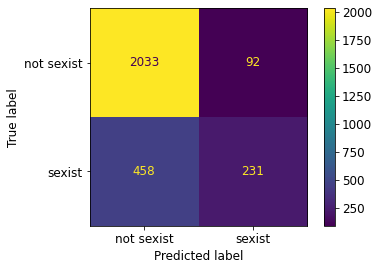

In [70]:
naive_bayes(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)


=== majority class ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.76      1.00      0.86      2125
      sexist       0.00      0.00      0.00       689

    accuracy                           0.76      2814
   macro avg       0.38      0.50      0.43      2814
weighted avg       0.57      0.76      0.65      2814

Confusion Matrix:
[[2125    0]
 [ 689    0]]


<Figure size 7200x4800 with 0 Axes>

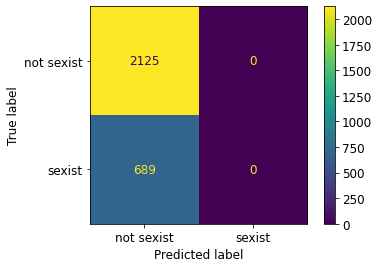

In [71]:
majority_class(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)


=== SVM ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.86      0.90      0.88      2125
      sexist       0.63      0.53      0.58       689

    accuracy                           0.81      2814
   macro avg       0.74      0.71      0.73      2814
weighted avg       0.80      0.81      0.80      2814

Confusion Matrix:
[[1908  217]
 [ 323  366]]


<Figure size 7200x4800 with 0 Axes>

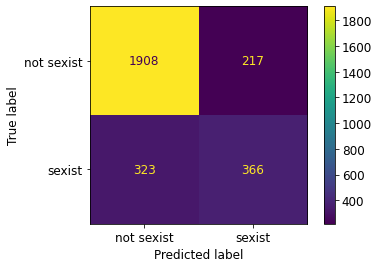

In [72]:
svm_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)


=== decision tree ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.84      0.88      0.86      2125
      sexist       0.58      0.50      0.54       689

    accuracy                           0.79      2814
   macro avg       0.71      0.69      0.70      2814
weighted avg       0.78      0.79      0.78      2814

Confusion Matrix:
[[1875  250]
 [ 345  344]]


<Figure size 7200x4800 with 0 Axes>

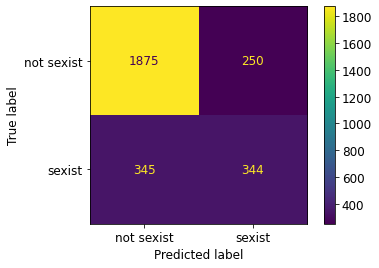

In [73]:
decision_tree_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

In [74]:
## Running Task B (Multi-class) 

In [75]:
task_name = 'taskB'
le = LabelEncoder()

le.fit(y_train_b)
y_train_b = le.transform(y_train_b)


=== naive bayes ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        58
                           2. derogation       0.49      0.10      0.16       297
                            3. animosity       0.38      0.02      0.04       251
               4. prejudiced discussions       1.00      0.00      0.00        67
                                    none       0.78      0.99      0.87      2141

                                accuracy                           0.77      2814
                               macro avg       0.53      0.22      0.21      2814
                            weighted avg       0.70      0.77      0.68      2814

Confusion Matrix:
[[   0    1    0    0   57]
 [   0   29    5    0  263]
 [   0   20    5    0  226]
 [   0    0    0    0   67]
 [   1    9    3    0 2128]]


<Figure size 7200x4800 with 0 Axes>

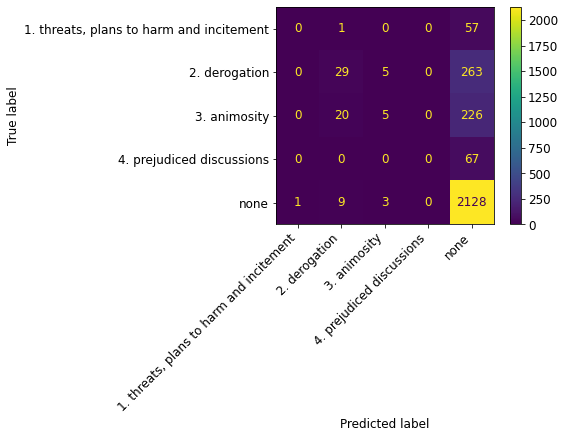

In [76]:
naive_bayes(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)


=== majority class ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        58
                           2. derogation       0.00      0.00      0.00       297
                            3. animosity       0.00      0.00      0.00       251
               4. prejudiced discussions       0.00      0.00      0.00        67
                                    none       0.76      1.00      0.86      2141

                                accuracy                           0.76      2814
                               macro avg       0.15      0.20      0.17      2814
                            weighted avg       0.58      0.76      0.66      2814

Confusion Matrix:
[[   0    0    0    0   58]
 [   0    0    0    0  297]
 [   0    0    0    0  251]
 [   0    0    0    0   67]
 [   0    0    0    0 2141]]


<Figure size 7200x4800 with 0 Axes>

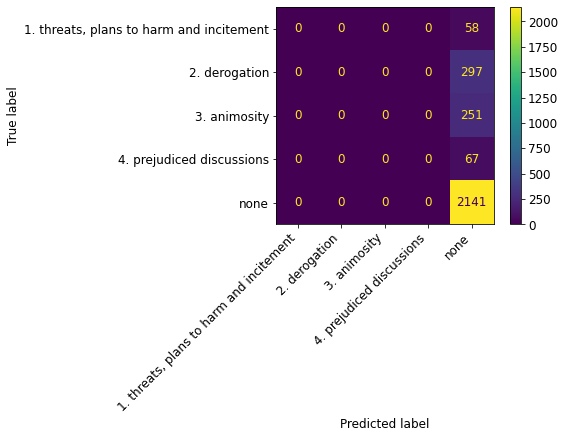

In [77]:
majority_class(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)


=== SVM ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.16      0.14      0.15        58
                           2. derogation       0.35      0.37      0.36       297
                            3. animosity       0.38      0.28      0.32       251
               4. prejudiced discussions       0.24      0.16      0.19        67
                                    none       0.86      0.89      0.88      2141

                                accuracy                           0.75      2814
                               macro avg       0.40      0.37      0.38      2814
                            weighted avg       0.73      0.75      0.74      2814

Confusion Matrix:
[[   8    5    5    0   40]
 [   9  111   39    5  133]
 [   9   72   70    7   93]
 [   1    5    6   11   44]
 [  23  122   63   23 1910]]


<Figure size 7200x4800 with 0 Axes>

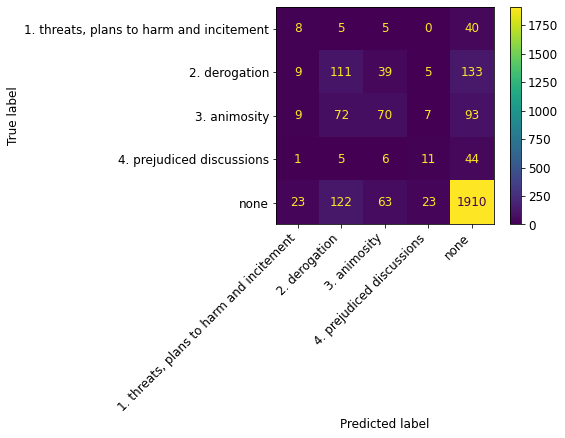

In [78]:
svm_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)


=== decision tree ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.08      0.05      0.06        58
                           2. derogation       0.34      0.31      0.32       297
                            3. animosity       0.38      0.29      0.33       251
               4. prejudiced discussions       0.12      0.07      0.09        67
                                    none       0.85      0.90      0.87      2141

                                accuracy                           0.75      2814
                               macro avg       0.35      0.33      0.34      2814
                            weighted avg       0.72      0.75      0.73      2814

Confusion Matrix:
[[   3    7    8    1   39]
 [   5   91   48    4  149]
 [   6   54   73    4  114]
 [   1    9    9    5   43]
 [  22  104   56   27 1932]]


<Figure size 7200x4800 with 0 Axes>

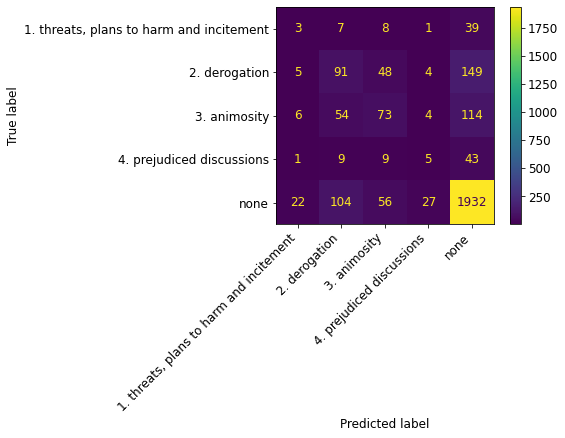

In [79]:
decision_tree_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)